<a href="https://colab.research.google.com/github/Aromanor/Oxford-IIIpet---clasificador/blob/main/PF_visi%C3%B3n_por_computador_Alvaro_Romano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto final - Visión por computador
Alvaro Romano Rojas

##1. Configuración Inicial (GPU, Precision Mixta y XLA)

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import seaborn as sns

# Configuración de la GPU y memoria dinámica
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Mostrar la versión de TensorFlow
print(tf.__version__)


2.17.0


In [2]:
# Montar Google Drive para acceder a los datos almacenados
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##2. Definición de Parámetros del Modelo

In [3]:
# Parámetros de los datos
BASE_PATH = "/content/drive/MyDrive/pf_imagenes/images"
TB_LOGS = "/content/drive/MyDrive/pf_imagenes/tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1

# Parámetros del modelo
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0001
PLOTS_DPI = 200


##3. Cargar y Explorar el Dataset

In [4]:
# Obtener los nombres de las imágenes
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]
print(f"\nTotal number of image files: {len(imageNames)}")

# Extraer las etiquetas (razas) desde los nombres de los archivos
labels = [' '.join(name.split('_')[:-1]) for name in imageNames]
print(f"\nTotal number of unique labels: {len(np.unique(labels))}")

# Crear diccionarios de codificación
labelEncDict = {name: ind for ind, name in enumerate(np.unique(labels))}
labelDecDict = {ind: name for name, ind in labelEncDict.items()}

# Mostrar distribución de clases
for i in labelEncDict.keys():
    print(f"{i:32} : {labels.count(i)}")



Total number of image files: 7402

Total number of unique labels: 37
Abyssinian                       : 200
Bengal                           : 200
Birman                           : 200
Bombay                           : 200
British Shorthair                : 200
Egyptian Mau                     : 200
Maine Coon                       : 200
Persian                          : 200
Ragdoll                          : 200
Russian Blue                     : 200
Siamese                          : 200
Sphynx                           : 210
american bulldog                 : 200
american pit bull terrier        : 200
basset hound                     : 200
beagle                           : 200
boxer                            : 200
chihuahua                        : 200
english cocker spaniel           : 200
english setter                   : 200
german shorthaired               : 200
great pyrenees                   : 201
havanese                         : 200
japanese chin                    

##**4. Graficar Distribución de Clases**

<ipython-input-6-0f2fffd6453e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="viridis")


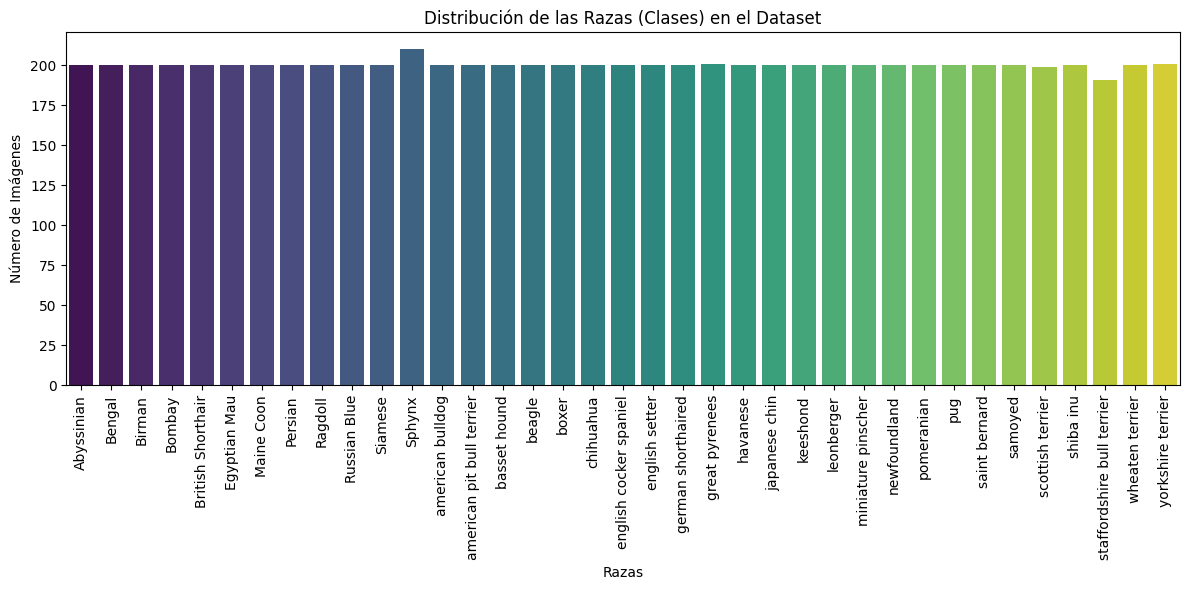

In [6]:
# Visualizar la distribución de las clases en un gráfico
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_labels, y=counts, palette="viridis")
plt.xticks(rotation=90)
plt.title('Distribución de las Razas (Clases) en el Dataset')
plt.xlabel('Razas')
plt.ylabel('Número de Imágenes')
plt.tight_layout()
plt.show()


##5. Cargar las Imágenes en Arrays Numpy

In [7]:
# Cargar imágenes y redimensionarlas
imageData = []
for name in tqdm(imageNames, desc='Loading image data', unit=' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype='uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)

imageData = np.array(imageData)
print(imageData.shape)


Loading image data: 100%|██████████| 7402/7402 [05:13<00:00, 23.63 images/s]


(7402, 256, 256, 3)


##6. Preparación de los Datos (Train, Validation, Test)

In [8]:
# Codificar las etiquetas
labelsEncoded = list(map(lambda x: labelEncDict.get(x), labels))

# División de los datos en conjunto de entrenamiento, validación y prueba
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData, labelsEncoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labelsEncoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_tv, y_tv, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_tv
)

print(f'Training Data: {X_train.shape}')
print(f'Validation Data: {X_val.shape}')
print(f'Testing Data: {X_test.shape}')

# Eliminar variables innecesarias para reducir el uso de memoria
del imageData, labelsEncoded, X_tv, y_tv


Training Data: (5994, 256, 256, 3)
Validation Data: (667, 256, 256, 3)
Testing Data: (741, 256, 256, 3)


##7. Data Augmentation y Generadores de Imágenes

In [9]:
# Generador de datos de entrenamiento con aumentación
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = train_gen.flow(x=X_train, y=y_train, batch_size=BATCH_SIZE, shuffle=True)

# Generador de datos de validación
val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow(x=X_val, y=y_val, batch_size=BATCH_SIZE, shuffle=True)

# Generador de datos de prueba
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow(x=X_test, y=y_test, batch_size=BATCH_SIZE)


##8. Definir el Modelo Preentrenado ResNet50 con Fine-Tuning

In [10]:
# Cargar el modelo preentrenado ResNet50
with tf.device('/GPU:0'):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Descongelar algunas capas del modelo preentrenado para fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  # Solo descongelar las últimas 10 capas
        layer.trainable = True

    # Añadir capas personalizadas
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)  # Añadir Dropout
    predictions = Dense(len(labelEncDict), activation='softmax')(x)

    # Compilar el modelo
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,723,813 (98.13 MB)

 Trainable params: 25,670,693 (97.93 MB)

 Non-trainable params: 53,120 (207.50 KB)

##9. Entrenamiento del Modelo con Callbacks y Pesos de Clase

In [11]:
from sklearn.utils import class_weight

# Pesos de clase para manejar desbalance de clases
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Callbacks
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
tensorBoard = TensorBoard(log_dir=TB_LOGS, histogram_freq=10)

# Entrenar el modelo con pesos de clase
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[earlyStop, tensorBoard, reduce_lr],
    class_weight=class_weights_dict  # Aplicar pesos de clase
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3440 - loss: 3.8802 - val_accuracy: 0.0270 - val_loss: 5.0651 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 797ms/step - accuracy: 0.8390 - loss: 1.8421 - val_accuracy: 0.0285 - val_loss: 5.0203 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 802ms/step - accuracy: 0.8923 - loss: 1.6348 - val_accuracy: 0.0270 - val_loss: 4.9866 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.9326 - loss: 1.4907 - val_accuracy: 0.0210 - val_loss: 4.9389 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.9509 - loss: 1.3836 - val_accuracy: 0.0630 - val_loss: 4.7135 - learning_rate: 1.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 797ms/step - accuracy: 0.9506 - loss: 1.3466 - val_accuracy: 0.2774 - val_loss: 3.8029 - learning_rate: 1.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 797ms/step - accuracy: 0.9651

##10. Evaluar el Modelo en los Datos de Prueba

In [12]:
# Evaluar el modelo en los datos de prueba
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - accuracy: 0.9025 - loss: 0.6545
Loss on Testing data: 0.6322646141052246
Accuracy on Testing data: 0.9001349806785583


##11. Visualización de Resultados del Entrenamiento

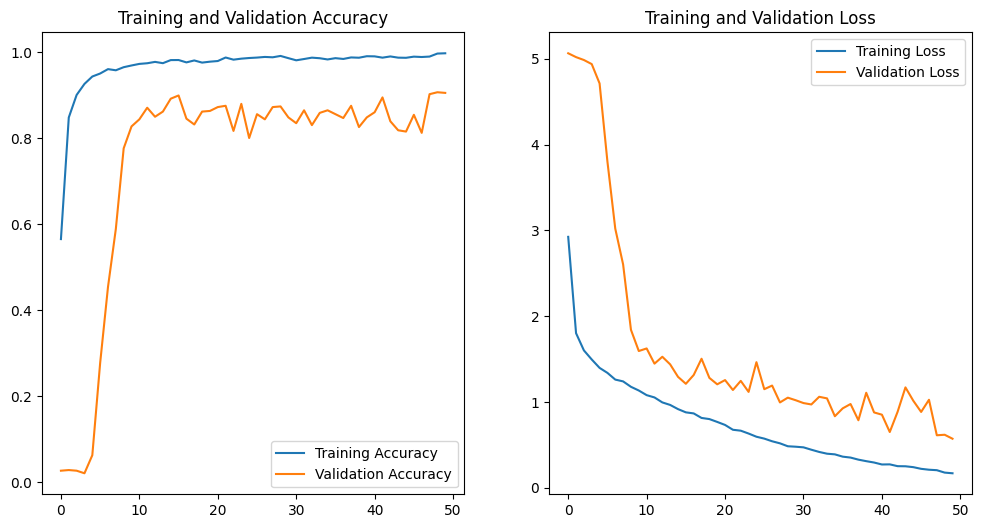

In [13]:
# Visualizar los resultados del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


##12. Matriz de Confusión y ejemplo de clases predichas

In [17]:
# Generar predicciones para los datos de prueba
y_pred = np.argmax(model.predict(X_test / 255.0), axis=1)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


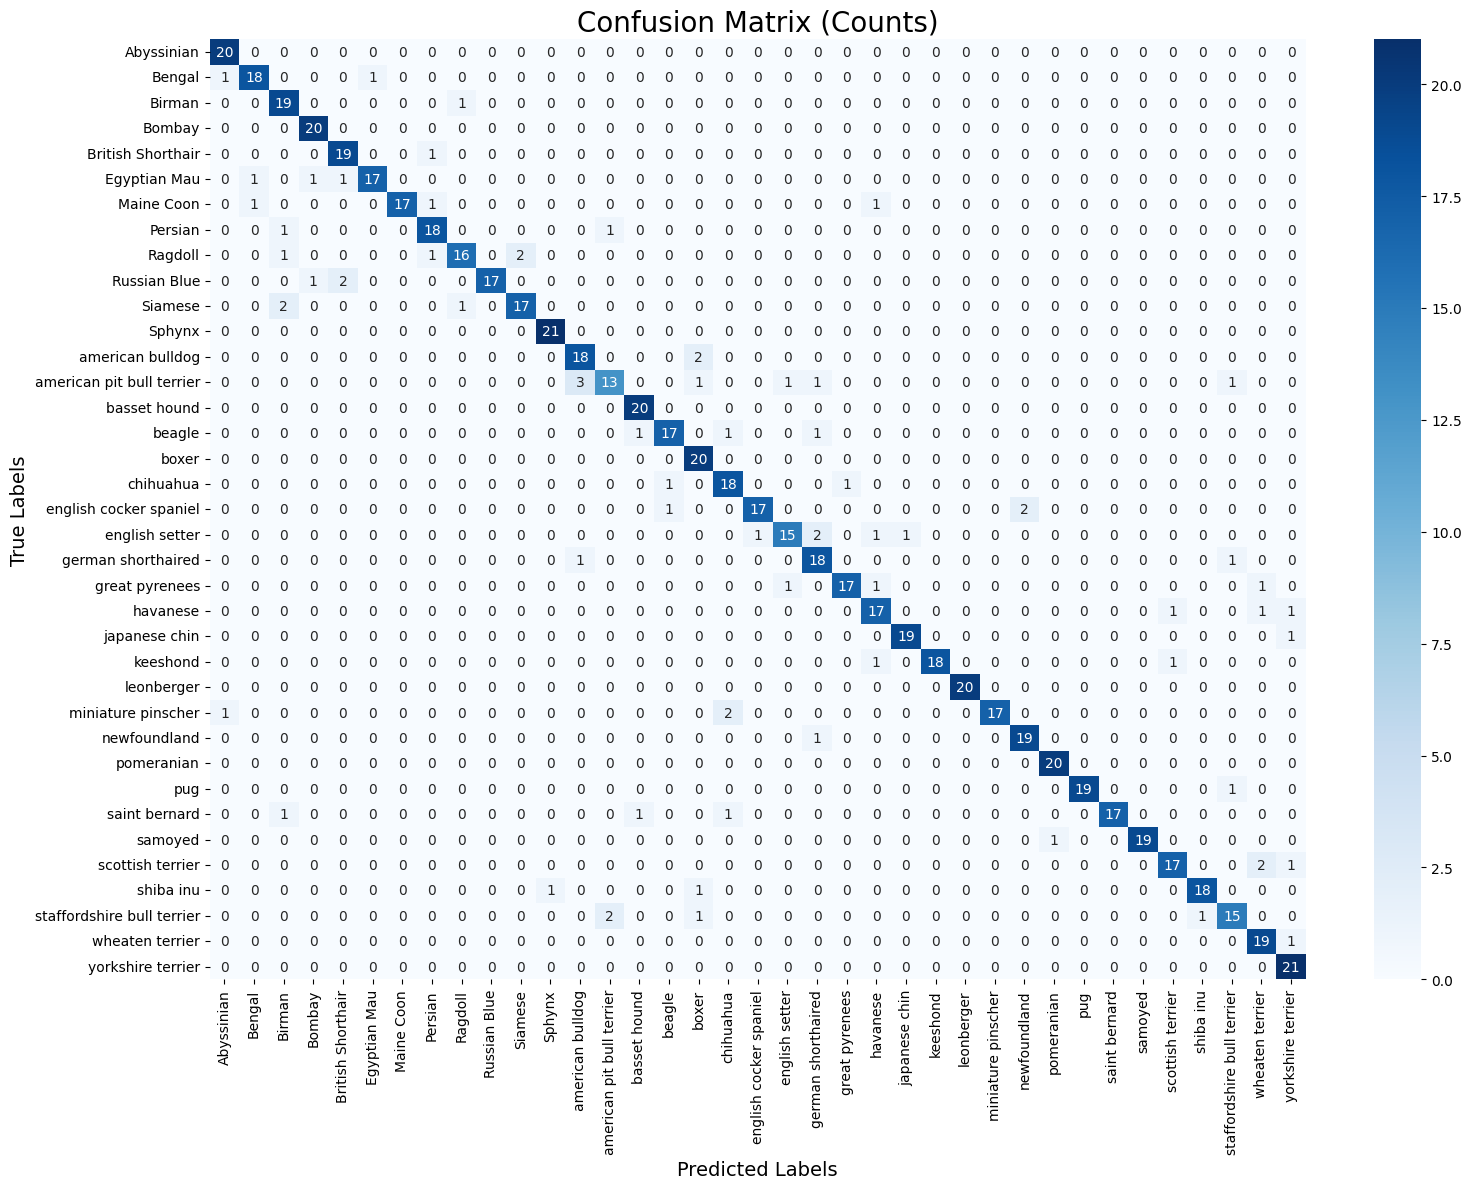

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 12))

# Crear el heatmap usando seaborn con los valores exactos (sin normalización)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=list(labelDecDict.values()), yticklabels=list(labelDecDict.values()))

# Añadir títulos y etiquetas
plt.title('Confusion Matrix (Counts)', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para que no se superpongan
plt.yticks(rotation=0)

# Mostrar la matriz de confusión
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


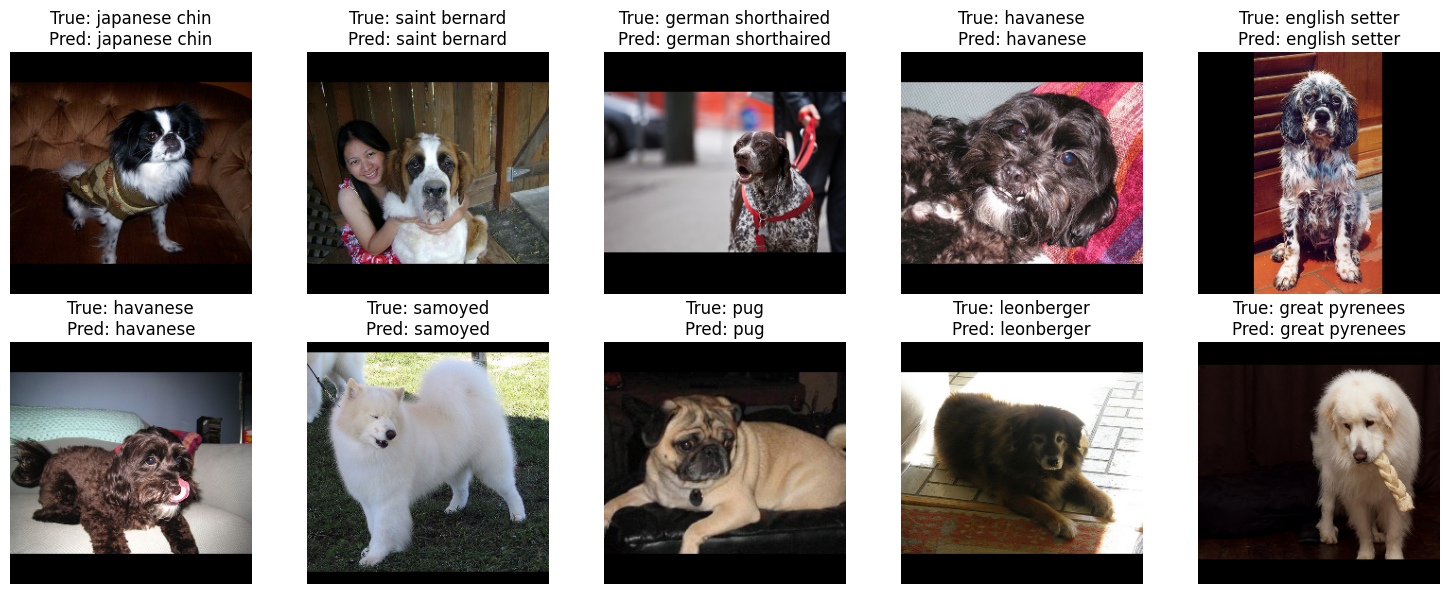

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar 10 índices aleatorios del conjunto de prueba
random_indices = random.sample(range(len(X_test)), 10)

# Obtener las imágenes, etiquetas verdaderas y predicciones para esos índices
images = X_test[random_indices]
true_labels = np.array(y_test)[random_indices]
pred_labels = np.argmax(model.predict(images / 255.0), axis=1)

# Crear un gráfico de 2x5 para mostrar 10 imágenes
plt.figure(figsize=(15, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)  # Crear subgráficas en una cuadrícula de 2 filas y 5 columnas
    plt.imshow(images[i])
    true_label_name = labelDecDict[true_labels[i]]
    pred_label_name = labelDecDict[pred_labels[i]]
    plt.title(f'True: {true_label_name}\nPred: {pred_label_name}')
    plt.axis('off')  # Ocultar los ejes para que se vea más limpio

# Mostrar el gráfico
plt.tight_layout()
plt.show()


#Guardado de modelo y pruebas

In [32]:
# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/pf_imagenes/models/pet_image_classifier_resnet50_finetuned.h5')


In [33]:
import json

# Guardar el diccionario de etiquetas (labelDecDict) en un archivo JSON
with open('/content/drive/MyDrive/pf_imagenes/models/label_dict.json', 'w') as fp:
    json.dump(labelDecDict, fp)


##Carga de imagen de prueba

Saving Bsst Hnd.jpg to Bsst Hnd.jpg


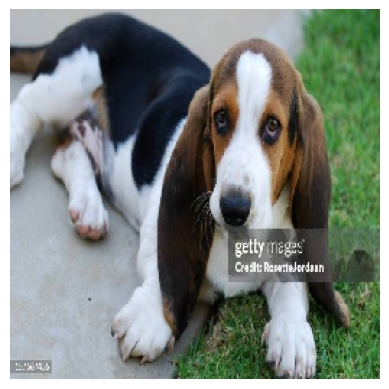

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
La imagen ha sido clasificada como: basset hound


In [31]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Función para cargar y predecir la clase de una nueva imagen
def predict_new_image(model, labelDecDict, image_size=(256, 256)):
    # Subir una imagen desde tu sistema de archivos
    uploaded = files.upload()

    # Obtener el nombre de la imagen subida
    for filename in uploaded.keys():
        img_path = filename

    # Cargar la imagen y redimensionarla al tamaño que espera el modelo
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normalizar la imagen
    img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para batch

    # Mostrar la imagen cargada
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Hacer la predicción con el modelo
    pred = np.argmax(model.predict(img_array), axis=1)[0]

    # Obtener el nombre de la clase predicha
    predicted_label = labelDecDict[pred]

    print(f'La imagen ha sido clasificada como: {predicted_label}')

# Llamar a la función para cargar y predecir
predict_new_image(model, labelDecDict)


Saving Bgle.png to Bgle (1).png


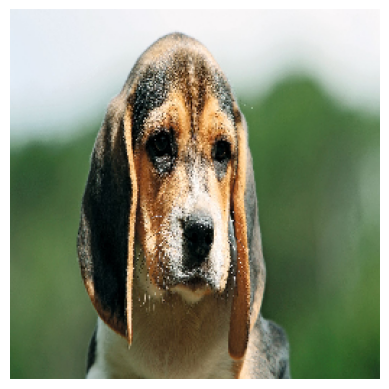

Selecciona la etiqueta correcta para esta imagen:
0: Abyssinian
1: Bengal
2: Birman
3: Bombay
4: British Shorthair
5: Egyptian Mau
6: Maine Coon
7: Persian
8: Ragdoll
9: Russian Blue
10: Siamese
11: Sphynx
12: american bulldog
13: american pit bull terrier
14: basset hound
15: beagle
16: boxer
17: chihuahua
18: english cocker spaniel
19: english setter
20: german shorthaired
21: great pyrenees
22: havanese
23: japanese chin
24: keeshond
25: leonberger
26: miniature pinscher
27: newfoundland
28: pomeranian
29: pug
30: saint bernard
31: samoyed
32: scottish terrier
33: shiba inu
34: staffordshire bull terrier
35: wheaten terrier
36: yorkshire terrier
Ingresa el número correspondiente a la clase correcta: 15
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.0000e+00 - loss: 3.7922
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0000e+00 - loss: 4.1236
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0000e+00 - loss: 3.8083
Epoch 4/5
1/1 ━━━━━━━━━━━━━

In [28]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Función para cargar una imagen, mostrarla y seleccionar su etiqueta
def add_new_image_and_train(model, labelEncDict, labelDecDict, image_size=(256, 256)):
    # Subir una imagen desde tu sistema de archivos
    uploaded = files.upload()

    # Obtener el nombre de la imagen cargada
    for filename in uploaded.keys():
        img_path = filename

    # Cargar y mostrar la imagen
    img = load_img(img_path, target_size=image_size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convertir la imagen en un array y normalizarla
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión de batch

    # Mostrar la lista de clases para seleccionar la etiqueta correcta
    print("Selecciona la etiqueta correcta para esta imagen:")
    for i, label in labelDecDict.items():
        print(f"{i}: {label}")

    # Ingresar manualmente la etiqueta correcta
    correct_label = int(input("Ingresa el número correspondiente a la clase correcta: "))

    # Convertir la etiqueta a formato array
    y_true = np.array([correct_label])

    # Fine-tuning: entrenar el modelo solo en esta nueva imagen
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(img_array, y_true, epochs=5, verbose=1)

    print(f"El modelo ha aprendido de la imagen etiquetada como: {labelDecDict[correct_label]}")

# Llamar a la función para cargar, etiquetar y entrenar
add_new_image_and_train(model, labelEncDict, labelDecDict)
